<a href="https://colab.research.google.com/github/Gk58IISERTvm98/Extract_Table_From_ImageFile/blob/main/Extract_Table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install paddlepaddle
!pip install paddleocr

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image

In [ ]:
from paddleocr import PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:19<00:00, 198.77it/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:22<00:00, 436.86it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:14<00:00, 147.46it/s]

[2024/10/19 19:40:03] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [ ]:
import numpy as np
import pandas as pd

class OCRTableExtractor:
    def __init__(self, image_path):
        """
        Initializes the OCRTableExtractor with the image path and OCR model.
        """
        self.image_path = image_path
        self.result = None
        self.table = None
        self.my_table = None
        self.x_min = []
        self.x_max = []
        self.length = []
        self.y_min = []
        self.y_max = []
        self.height = []
        self.text = []
        self.mh1 = None
        self.sh2 = None
        self.sh3 = None

    def process_image(self):
        """
        Perform OCR on the image and process the results to extract table structure.
        """
        result = ocr.ocr(self.image_path, cls=True)
        for line in result:
            for word_info in line:
                x_mi = []; y_mi = []
                for cor in word_info[0]:
                    x_mi.append(cor[0])
                    y_mi.append(cor[1])
                self.x_min.append(min(x_mi))
                self.x_max.append(max(x_mi))
                self.y_min.append(min(y_mi))
                self.y_max.append(max(y_mi))
                self.length.append(max(x_mi) - min(x_mi))
                self.height.append(max(y_mi) - min(y_mi))
                self.text.append(word_info[1][0])

        self.table = pd.DataFrame({
            'X_min': self.x_min,
            'Y_min': self.y_min,
            'X_max': self.x_max,
            'Y_max': self.y_max,
            'text': self.text,
            'length': self.length,
            'height': self.height
            })

    def XY_majorNode(self):
        """
        Computes major X and Y nodes for structuring the table based on coordinates.
        """
        x_min_unique = np.unique(self.table['X_min']).astype(int)
        x_min_unique.sort()

        y_max_unique = np.unique(self.table['Y_max']).astype(int)
        y_max_unique.sort()

        X_node = [min(x_min_unique)]
        ln = int(np.mean(self.table['length']))
        nx = min(x_min_unique)

        for i in x_min_unique:
            if i >= nx + ln:
                nx = i
                X_node.append(i)

        Y_node = []; Tn = int(np.mean(self.table['height']))
        ny = 0
        for i in y_max_unique:
            for j in y_max_unique:
                if j - i >= Tn+1 and i >= ny:
                    ny = j
                    Y_node.append(i)
                    break
        Y_node.append(ny)

        return X_node, Y_node

    def assign_x_node(self, x_mj):
        x_cor_assigned = []
        for x in self.table['X_min']:
            for i in range(len(x_mj) - 1):
                if x_mj[i] <= x < x_mj[i + 1]:
                    x_cor_assigned.append(i)
                    break
            if x >= max(x_mj):
                x_cor_assigned.append(len(x_mj) - 1)
        return x_cor_assigned

    def assign_y_node(self, y_mj):
            y_min_unique = np.unique(self.table['Y_min']).astype(int)
            y_min_unique.sort()
            y_cor_assigned = []
            for y in self.table['Y_min']: # Iterate through all Y_min values in self.table
                for i in range(len(y_mj)):
                    if y <= y_mj[i]:
                        y_cor_assigned.append(i)
                        break
            return y_cor_assigned

    def create_table(self):
        x_mj, y_mj = self.XY_majorNode()

        self.table['X_node'] = self.assign_x_node(x_mj)
        self.table['Y_node'] = self.assign_y_node(y_mj)

        self.table.sort_values(by=['Y_min', 'X_min'], inplace=True)
        self.table.reset_index(drop=True, inplace=True)
        self.table = self.table.groupby(['X_node', 'Y_node'], as_index=False).agg({'text': ' '.join})

        self.my_table = pd.DataFrame(0, index=range(len(y_mj)), columns=range(len(x_mj)))
        for i in range(len(self.table)):
            self.my_table.iloc[self.table['Y_node'][i], self.table['X_node'][i]] = self.table['text'][i]

        self.my_table = self.my_table.replace(0, np.nan)
        self.my_table = self.my_table.dropna(axis=1, how='all')
        self.my_table = self.my_table.dropna(axis=0, how='all')
        self.my_table = self.my_table.fillna('')

        # Creates the multi-level header based on the extracted text.
        self.mh1 =  [item.strip() for item in self.my_table.iloc[0].values if item.strip() != '']
        self.sh2 = self.my_table.iloc[1].values
        self.sh3 = self.my_table.iloc[2].values

        header = [self.mh1 * len(self.my_table.columns),self.sh2,self.sh3]
        new_header = pd.MultiIndex.from_arrays(header)
        self.New_table = pd.DataFrame(self.my_table.iloc[3:].values, columns=new_header)

    def save_to_MD_Table(self, file_index=0):
        html_table = self.New_table.to_html()
        file_path = f"Markdown_Table/{file_index}.md"
        with open(file_path, "w") as file:
            file.write(html_table)



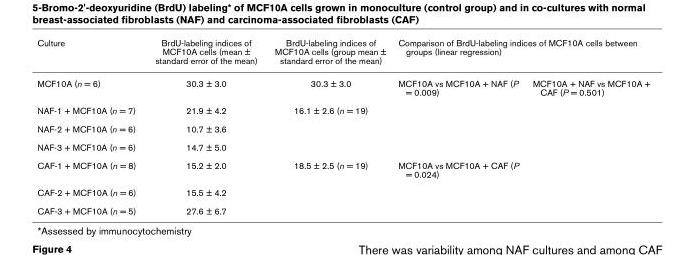

In [ ]:
image_path = "/content/PMC1064098_table_0.jpg"
img = Image.open(image_path)
display(img)

In [ ]:
extractor = OCRTableExtractor(image_path)
extractor.process_image()
extractor.create_table()

[2024/10/19 19:55:50] ppocr DEBUG: dt_boxes num : 36, elapsed : 0.07872343063354492
[2024/10/19 19:55:51] ppocr DEBUG: cls num  : 36, elapsed : 0.0837864875793457
[2024/10/19 19:55:55] ppocr DEBUG: rec_res num  : 36, elapsed : 4.3316051959991455


In [ ]:
table = extractor.New_table
table

5-Bromo-2'-deoxyuridine BrdU) labeling of MCF10A cells grown in monoculture (control group) and in co-cultures with normal breast-associated fibroblasts (NAF) and carcinoma-associated fibroblasts (CAF)  \
                                                                                                                                                                                                    Culture   
                                                                                                                                                                                                              
0                                     MCF10A (n = 6)                                                                                                                                                          
1                                   NAF-1+MCF10An=7}                                                                                                                                                          
2                                    NAF-2+MCF10An=6                                                                                                                                                          
3                                  NAF-3+MCF10A(n=6)                                                                                                                                                          
4                                    CAF-1+MCF10An=8                                                                                                                                                          
5                                                                                                                                                                                                             
6                                   CAF-2+MCF10An=6)                                                                                                                                                          
7                                  CAF-3+MCF10A n=5)                                                                                                                                                          
8                    Assessed by immunocytochemistry                                                                                                                                                          
9                                            Figure4                                                                                                                                                          

                                               \
  BrdU-labeling indices of MCF10A cells (mean   
                  standard error of the mean)   
0                                   30.3  3.0   
1                                    21.9 4.2   
2                                     10.73.6   
3                                    14.7 5.0   
4                                   15.2  2.0   
5                                               
6                                   15.5  4.2   
7                                   27.6  6.7   
8                                               
9                                               

                                                    \
  BrdU-labeling indices of MCF10A cells group mean   
                       standard error of the mean)   
0                                        30.3  3.0   
1                                      16.12.6n=19   
2                                                    
3                                                    
4                                      18.52.5n=19   
5                                                    
6                                                    
7                                                    
8                                                    
9                       

In [ ]:
extractor.save_to_MD_Table(0)

In [ ]:
import os
import pandas as pd

os.makedirs("Table_MD", exist_ok=True)
os.makedirs("ImgError", exist_ok=True)
os.makedirs(os.path.join("ImgError", "Error_Files"), exist_ok=True)

image_directory = "/content/images"
image_files = [f for f in os.listdir(image_directory) if f.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]

# Loop through each image file
for image_file in image_files:
    try:
        image_path = os.path.join(image_directory, image_file)
        extractor = OCRTableExtractor(image_path)
        extractor.process_image()
        extractor.XY_majorNode()
        extractor.create_table()
        # Save the table to a markdown file named after the image file
        file_name = os.path.splitext(image_file)[0]
        extractor.save_to_MD_Table(file_name)
    except ValueError as e:
        print(f"Error processing {image_file}: {e}")
        # Save the error-causing image to the Error_Files folder
        error_file_path = os.path.join("ImgError", image_file)
        os.rename(os.path.join(image_directory, image_file), error_file_path)
        continue

print("Table extraction completed for all images.")

[2024/10/09 23:30:02] ppocr DEBUG: dt_boxes num : 109, elapsed : 0.23275017738342285
[2024/10/09 23:30:02] ppocr DEBUG: cls num  : 109, elapsed : 0.3062398433685303
[2024/10/09 23:30:09] ppocr DEBUG: rec_res num  : 109, elapsed : 7.585594177246094
[2024/10/09 23:30:10] ppocr DEBUG: dt_boxes num : 288, elapsed : 0.37358808517456055
[2024/10/09 23:30:11] ppocr DEBUG: cls num  : 288, elapsed : 0.772120475769043
[2024/10/09 23:30:27] ppocr DEBUG: rec_res num  : 288, elapsed : 16.27554965019226
[2024/10/09 23:30:28] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.17514395713806152
[2024/10/09 23:30:28] ppocr DEBUG: cls num  : 31, elapsed : 0.09116411209106445
[2024/10/09 23:30:30] ppocr DEBUG: rec_res num  : 31, elapsed : 2.6458070278167725
Error processing PMC1184081_table_3.jpg: Length of values (29) does not match length of index (30)
[2024/10/09 23:30:31] ppocr DEBUG: dt_boxes num : 176, elapsed : 0.320690393447876
[2024/10/09 23:30:31] ppocr DEBUG: cls num  : 176, elapsed : 0.5159676074981

In [ ]:
# !zip -r ImageError.zip /content/ImgError
# !zip -r MD_Table.zip /content/Table_MD


  adding: content/ImgError/ (stored 0%)
  adding: content/ImgError/PMC1184081_table_3.jpg (deflated 14%)
  adding: content/ImgError/PMC1064098_table_3.jpg (deflated 20%)
  adding: content/ImgError/PMC1459855_table_2.jpg (deflated 14%)
  adding: content/ImgError/PMC1156875_table_0.jpg (deflated 14%)
  adding: content/ImgError/PMC1173115_table_0.jpg (deflated 18%)
  adding: content/ImgError/PMC1079832_table_4.jpg (deflated 17%)
  adding: content/ImgError/PMC1277852_table_2.jpg (deflated 8%)
  adding: content/ImgError/PMC1334194_table_1.jpg (deflated 17%)
  adding: content/ImgError/PMC1318486_table_5.jpg (deflated 14%)
  adding: content/ImgError/PMC1479382_table_2.jpg (deflated 18%)
  adding: content/ImgError/PMC1386659_table_0.jpg (deflated 13%)
  adding: content/ImgError/PMC1414017_table_1.jpg (deflated 18%)
  adding: content/ImgError/PMC1352387_table_0.jpg (deflated 7%)
  adding: content/ImgError/PMC1224853_table_9.jpg (deflated 24%)
  adding: content/ImgError/PMC1201163_table_0.jpg (d